The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

ret =  True


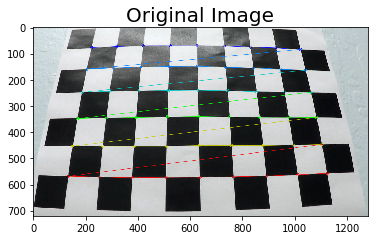

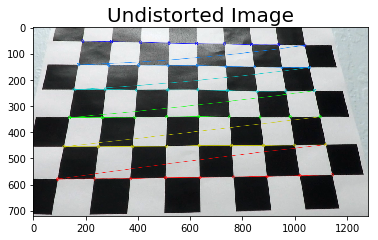

(<matplotlib.image.AxesImage at 0x118d76748>,
 None)

In [36]:
# Camera Calibration and Distortion Correction 
# The images for camera calibration are stored in the folder called camera_cal

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Read in an image
img = cv2.imread('camera_cal/calibration3.jpg')

# Initialize object points and image points arrays
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
objpoints = []
imgpoints = []

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
print('ret = ',ret)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    objpoints.append(objp)
    imgpoints.append(corners)
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
# Input: image, object points, and image points
# Perform camera calibration, image distortion correction and 
# return the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Calibrate
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# Run calibration and undistortion
undistorted = cal_undistort(img, objpoints, imgpoints)

plt.imshow(img), plt.title('Original Image', fontsize=20), plt.show()
plt.imshow(undistorted), plt.title('Undistorted Image', fontsize=20), plt.show()

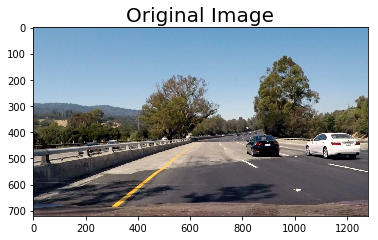

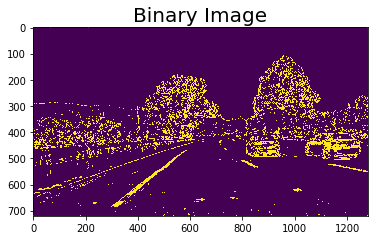

In [37]:
# Thresholding using color and gradient

# Load image
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test4.jpg')

# Threshold function
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Generate combined binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary >= 1) | (s_binary >= 1)] = 1
    return combined_binary
    
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary
    
thresh_image = pipeline(image)

#Plot the result
plt.imshow(image), plt.title('Original Image', fontsize=20)
plt.show()
plt.imshow(thresh_image), plt.title('Binary Image', fontsize=20)
plt.show()



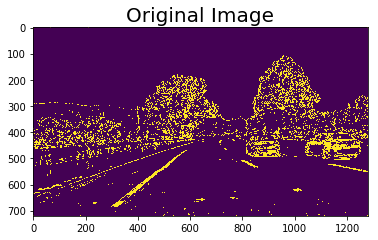

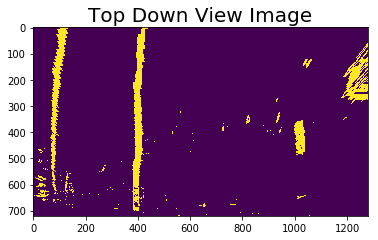

In [38]:
# Perspective Transform

# Read in an image
#img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test2.jpg')
img = thresh_image

# Source and destination points
src = np.float32([[(200, 720), (565, 470), (725, 470), (1130, 720)]])
dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])

# Find perspective transform matrix and inverse
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Image size
img_size = (img.shape[1], img.shape[0])

# Warp to top-down view 
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(img), plt.title('Original Image', fontsize=20)
plt.show()
plt.imshow(warped), plt.title('Top Down View Image', fontsize=20)
plt.show()

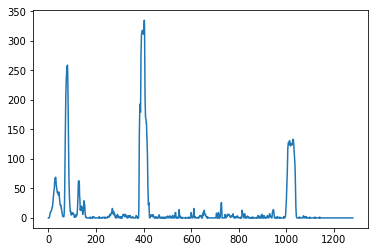

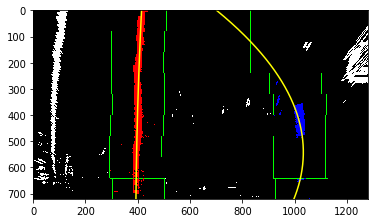

In [39]:
# Histogram method for finding lane lines. 
def find_lane_lines(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram), plt.show()

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Lane line fit colors
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, midpoint

# Call find_lane_lines
[left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, midpoint] = find_lane_lines(warped) 

#Visualization
#At this point, you're done! But here is how you can visualize the result as well:

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram), plt.show()
    
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

# Determine the curvature of the lane and vehicle position with respect to center.
def radius_of_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('Internal: ', left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad

# Plot up the fake data
#mark_size = 3
#plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
#plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
#plt.xlim(0, 1280)
#plt.ylim(0, 720)
#plt.plot(left_fitx, ploty, color='green', linewidth=3)
#plt.plot(right_fitx, ploty, color='green', linewidth=3)
#plt.gca().invert_yaxis() # to visualize as we do the images
#plt.show()


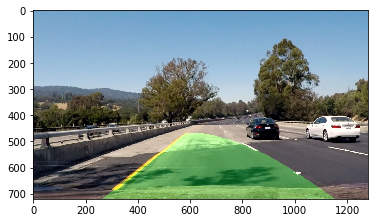

In [40]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()


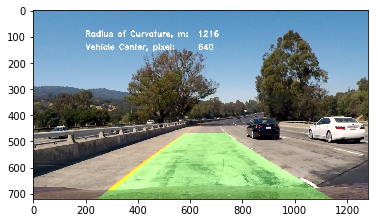

In [44]:
# Image Processing pipeline

def process_image(image):    
    # Thresholding    
    thresh_image = pipeline(image)

    # Warp to top-down view 
    warped = cv2.warpPerspective(thresh_image, M, img_size, flags=cv2.INTER_LINEAR)

    # Call find_lane_lines to find lane fit
    [left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, midpoint] = find_lane_lines(warped) 

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Calculate the radius of curvature
    [left_curverad, right_curverad] = radius_of_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx)
    avg_curverad = math.trunc((left_curverad + right_curverad) / 2)
    #print(left_curverad, 'm', right_curverad, 'm', avg_curverad, 'm')
    
    # Find midpoint
    xm_per_pix = 3.7/730
    veh_position = midpoint * xm_per_pix 
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Add radius of curevature annotation to frame
    font = cv2.FONT_HERSHEY_DUPLEX
    result1 = cv2.putText(result, "Radius of Curvature, m: ", (200,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result2 = cv2.putText(result1, str(avg_curverad), (630,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result1 = cv2.putText(result, "Vehicle Center, pixel: ", (200,150), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result2 = cv2.putText(result1, str(midpoint), (630,150), font, 1, (255,255,255), 2, cv2.LINE_AA)
   
    return result2
    
# Load image
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test1.jpg')
result = process_image(image)

plt.imshow(result)
plt.show()

In [45]:
# Generate and display video 
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'P4_vid_lanelines.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video P4_vid_lanelines.mp4
[MoviePy] Writing video P4_vid_lanelines.mp4


100%|█████████▉| 1260/1261 [02:42<00:00,  7.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_vid_lanelines.mp4 

CPU times: user 2min 35s, sys: 49.8 s, total: 3min 25s
Wall time: 2min 43s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))